In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Term Deposit Marketing.**

Term deposits are usually short-term deposits with maturities ranging from one month to a few years. 

A small startup focusing mainly on providing machine learning solutions in the European banking market is interested in developing a robust machine learning system that leverages information coming from call center data. They are looking for ways to improve the success rate for calls made to customers for any product that their clients offer. 

The goal is to build a machine learning product that offers high success outcomes while offering interpretability for their clients to make informed decisions.

The company is also interested in finding customers who are more likely to buy the investment product, in determining the segment(s) of customers their client should prioritize, and in what makes the customers buy.

**Import libraries.**

In [2]:
## data
import numpy as np
import pandas as pd

## visualisations
import seaborn as sns
import matplotlib.pyplot as plt

## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")

import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix,classification_report,PrecisionRecallDisplay
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

## shap
!pip install shap
import shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load the data.**

In [3]:
## Load data
data = pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


**Attributes:**

- age : age of customer (numeric)
 
- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary) i.e. has defaulted before?

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output (desired target):**

- y - has the client subscribed to a term deposit? (binary)

In [4]:
## dataset shape
nrows = data.shape[0]
ncols = data.shape[1]
print(f'Number of rows: {nrows}')
print(f'Number of columns: {ncols}')

Number of rows: 40000
Number of columns: 14


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


- There are $9$ categorical features and $5$ numerical features.

- There aren't any null values in the dataset.

## Let's begin with **Descriptive analysis (univariate analysis)** to understand the characteristics of each attribute of the dataset.

In [6]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


- Features 'balance', 'duration' and 'campaign' have some extreme values.
- 'Duration' has some $0$ entries, we should investigate them more.
- 'Balance' has some negative entried, we should investigate them more. 

In [7]:
print('balance:')
print(data[data['balance']<=0]['y'].value_counts())
print('----------------------------------------------')
print('duration:')
print(data[data['duration']==0]['y'].value_counts())


balance:
no     6564
yes     376
Name: y, dtype: int64
----------------------------------------------
duration:
no    3
Name: y, dtype: int64


- There are $376$ clients with non-positive balance who subscribed to a term deposit. This does not make sense. If the client does not have any money how can they subscribe to a term deposit?
- There are $3$ clients that did not answer their phone. All three of them have not subscribed. This makes sense.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


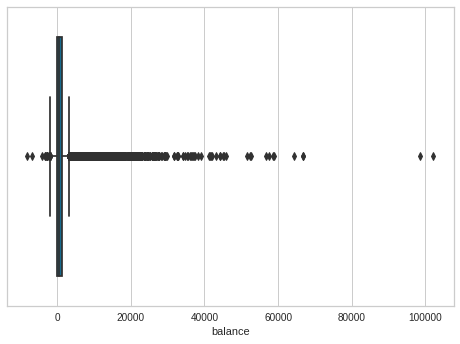

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


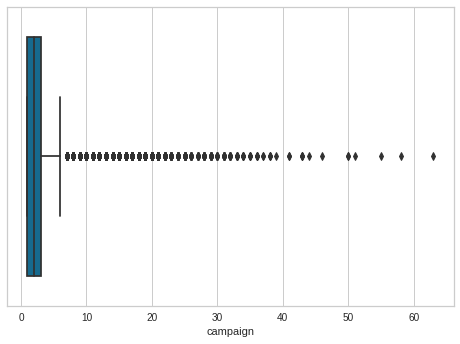

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


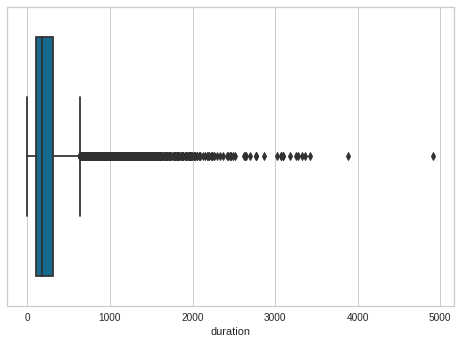

In [8]:
for col in ['balance','campaign','duration']:
  sns.boxplot(data[col])
  plt.show()

- From the box-plots we can see that there are clearly some outliers.

In [9]:
## categorical and numerical features

categorical_features = []
numerical_features = []
for col in data.columns:
  if data[col].dtype == 'object':
    categorical_features.append(col)
  elif data[col].dtype == 'int64':
    numerical_features.append(col)
print(f'Categorical features: {categorical_features}')
print(f'Numerical features: {numerical_features}')

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Numerical features: ['age', 'balance', 'day', 'duration', 'campaign']


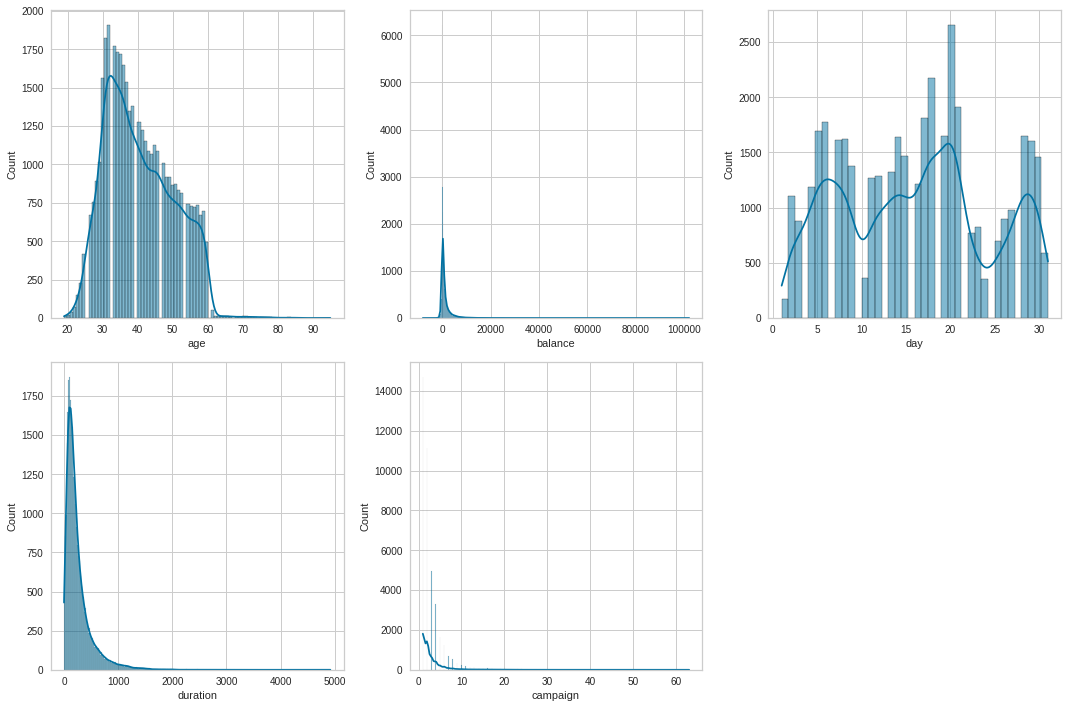

In [10]:
## distributions
plt.figure(figsize=(15,10))
i = 1 
for col in numerical_features:
  ax = plt.subplot(2,3,i)
  sns.histplot(data=data, x=col, kde=True)
  i+=1
plt.tight_layout()
plt.show()

- Almost all numerical features are right skewed.

In [11]:
## unique categories of each categorical feature
for col in categorical_features:
  print(f'Feature {col} has {len(data[col].unique())} unique categories.')
  print('--------------------------------------------------------------')

Feature job has 12 unique categories.
--------------------------------------------------------------
Feature marital has 3 unique categories.
--------------------------------------------------------------
Feature education has 4 unique categories.
--------------------------------------------------------------
Feature default has 2 unique categories.
--------------------------------------------------------------
Feature housing has 2 unique categories.
--------------------------------------------------------------
Feature loan has 2 unique categories.
--------------------------------------------------------------
Feature contact has 3 unique categories.
--------------------------------------------------------------
Feature month has 11 unique categories.
--------------------------------------------------------------
Feature y has 2 unique categories.
--------------------------------------------------------------


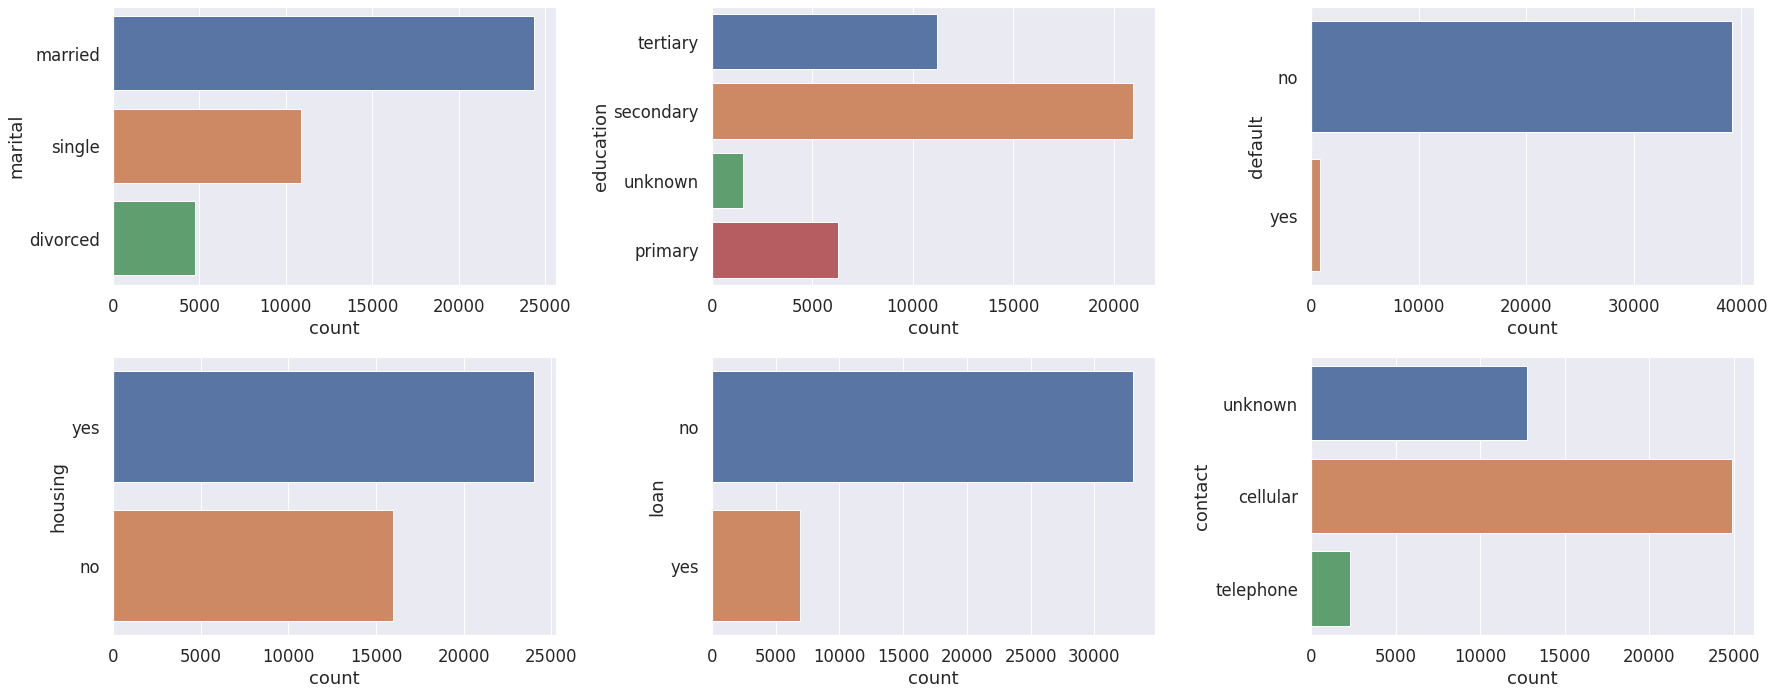

In [12]:
## countplots of categorical features
sns.set(font_scale = 1.5)
plt.figure(figsize=(25,10))
i=1
for col in ['marital', 'education', 'default', 'housing', 'loan', 'contact']:
	ax = plt.subplot(2,3,i)
	sns.countplot(y=col,data=data)
	i += 1
plt.tight_layout()
plt.show()

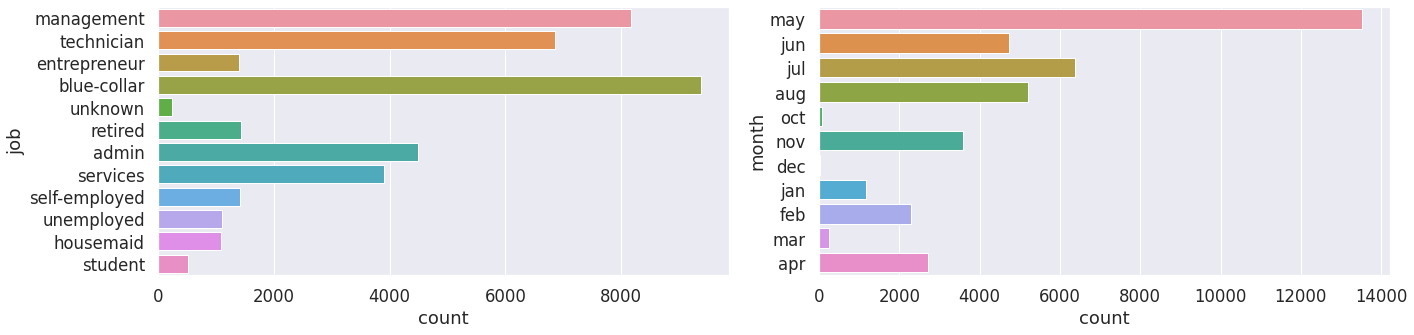

In [13]:
## countplots of categorical features
sns.set(font_scale = 1.5)
plt.figure(figsize=(20,5))
i=1
for col in ['job','month']:
	ax = plt.subplot(1,2,i)
	sns.countplot(y=col,data=data)
	i += 1
plt.tight_layout()
plt.show()

In [14]:
colsldh = ['loan','default','housing']
for i,col in enumerate(colsldh):
  v1 = data[data[col]=='yes'].shape[0]
  v2 = data[data[col]=='yes']['y'].value_counts()[0]
  if i==0:
    print(f'{v1}/{nrows} have a personal loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  elif i==1:
    print(f'{v1}/{nrows} have defaulted before.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  else:
    print(f'{v1}/{nrows} have a housing loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')

6930/40000 have a personal loan.
6550/6930 have not subscribed to a term deposit.
---------------------------------------------------
809/40000 have defaulted before.
760/809 have not subscribed to a term deposit.
---------------------------------------------------
24031/40000 have a housing loan.
22567/24031 have not subscribed to a term deposit.
---------------------------------------------------


- The vast majority of those who have defaulted before or have a personal loan or have a housing loan have not subscribed to a term deposit.

# **Correlation analysis (bivariate analysis)**

## **Qualitative analysis**

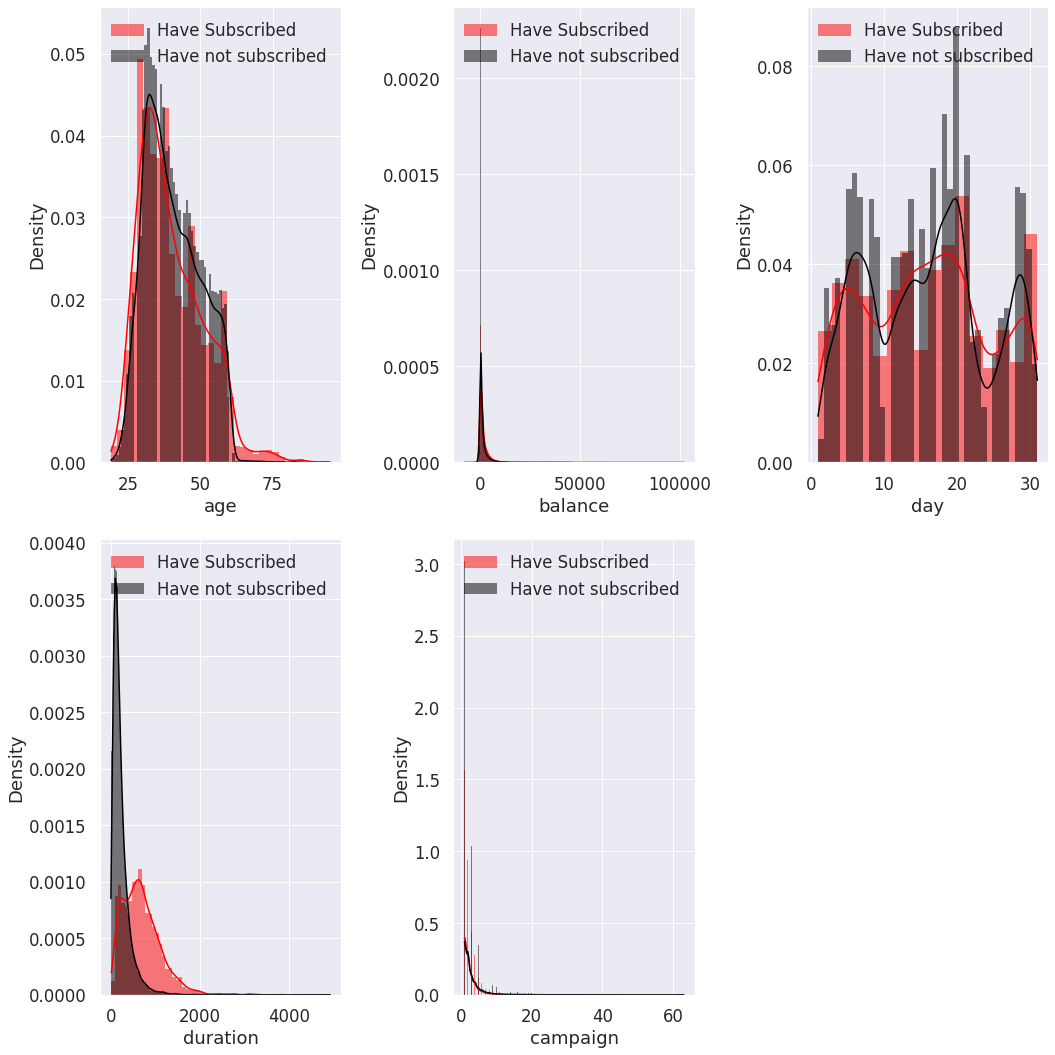

In [15]:
sub = data[data['y']=='yes']
sub_not = data[data['y']=='no']

plt.figure(figsize=(15,15))
i = 1 

for col in numerical_features: 
    ax = plt.subplot(2,3,i)
    sns.histplot(sub[col], color="red", label='Have Subscribed', kde=True, stat="density", linewidth=0)
    sns.histplot(sub_not[col], color="black", label='Have not subscribed', kde=True, stat="density", linewidth=0)
    plt.legend()
    i+=1
plt.tight_layout()
plt.show()

- We can only extract some information from the 'duration' histogram. People with longer last contact duration tend to subscribe a lot more.

In [16]:
## check for duplicates
data[data.duplicated(keep='first')].shape

(0, 14)

- There aren't any duplicates.

**Dealing with the categorical features.**

In [17]:
df = data.copy()
cols_yesno_to_01 = ['y','default','housing','loan']
[df[col].replace({'no':0, 'yes':1}, inplace=True) for col in cols_yesno_to_01]

[None, None, None, None]

**Numerical vs Numerical feature pairplot.**

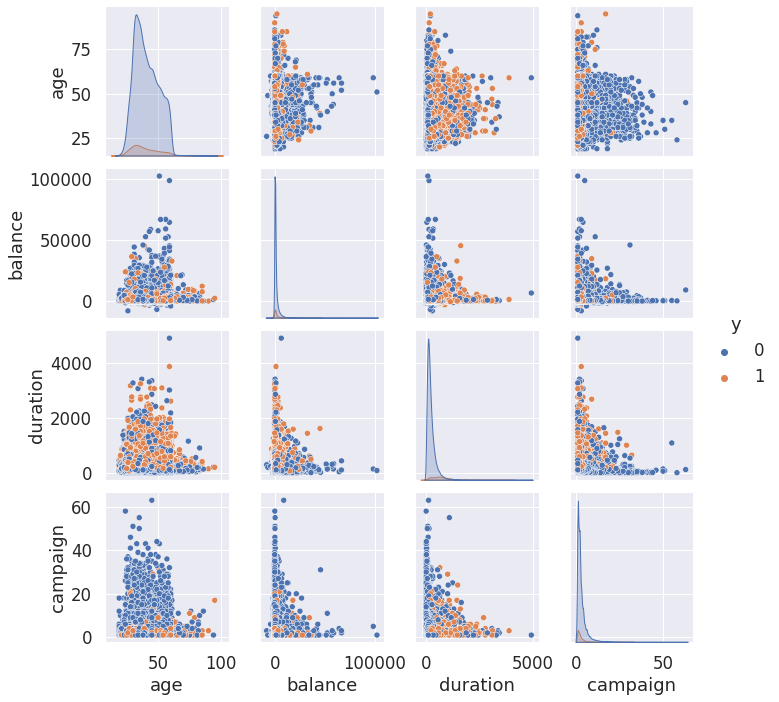

In [18]:
pairplot_df = df[['age', 'balance', 'duration', 'campaign','y']]
sns.pairplot(data=pairplot_df,hue='y')

**Barplots of categorical features based on the corresponding mean value of the target variable.**

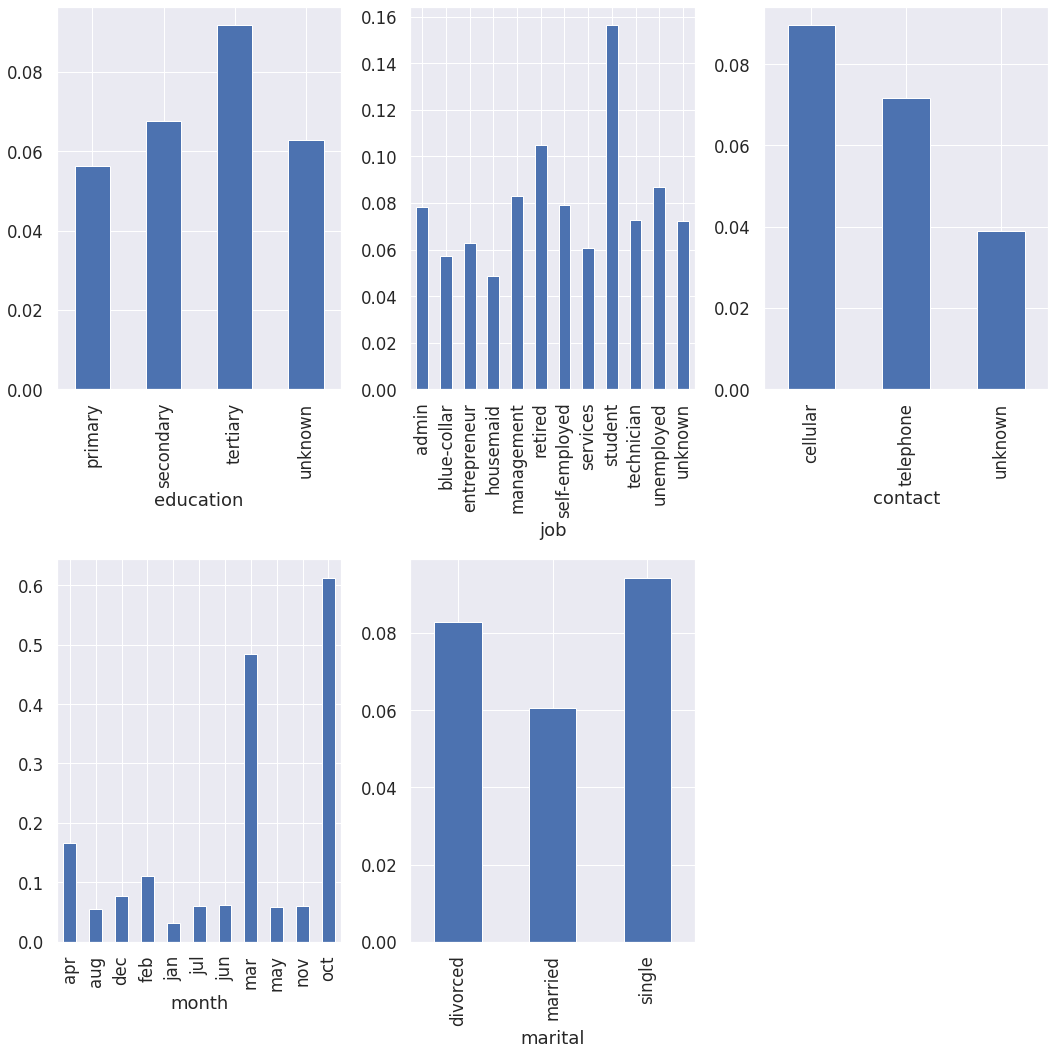

In [19]:
colsejcmm = ['education','job','contact','month','marital']
plt.figure(figsize=(15,15))
i = 1 
for col in colsejcmm:
  ax = plt.subplot(2,3,i)
  df.groupby([col])['y'].mean().plot.bar()
  i+=1
plt.tight_layout()
plt.show()

There is a higher probability to subscribing if:
- tetriary education
- student
- cellular contact
- last contact month was October
- single (marital) 

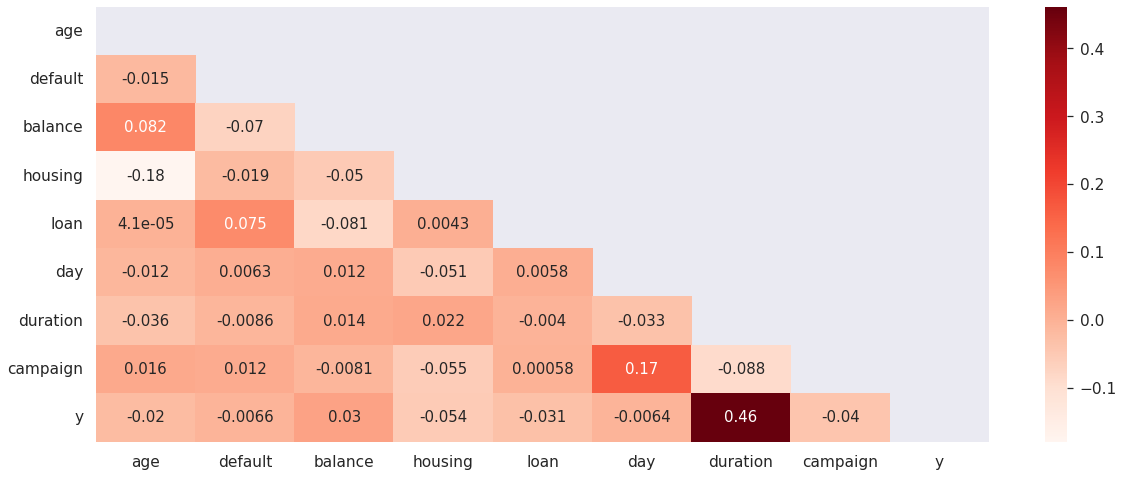

In [20]:
## Correlation Heatmap

sns.set(font_scale=1.4)
# correlation 
cor = df.corr('pearson')
matrix = np.triu(cor)

# heatmap to visualise the correlation
plt.figure(figsize=(20,8))
sns.heatmap(cor,annot=True, cmap=plt.cm.Reds, mask=matrix,annot_kws={'size': 15})
plt.show()

- Only 'duration' seems to be highly positively correlated with the target variable.
- There aren't any other strong correlations.

In [21]:
df = pd.get_dummies(df)
print(df.shape)

(40000, 42)


**Let's check for imbalanced data.**

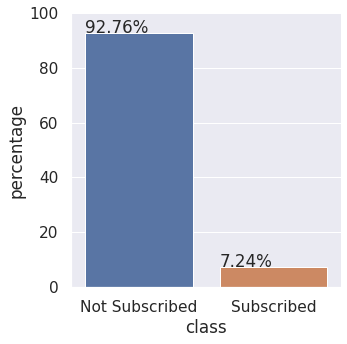

In [22]:
## Check for imbalanced data
df_ = df['y'].value_counts(normalize=True)
df_ = df_.mul(100)
df_ = df_.rename('percentage').reset_index()
df_['class'] = ['Not Subscribed','Subscribed']
g = sns.catplot(x='class',y='percentage',kind='bar',data=df_)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

- Our target variable is **highly imbalanced**.
- **Major class: Not Subscribed** to a term deposit.
- **Minor class: Subscribed** to a term deposit.

- To deal with the imbalanced data we will use the **SMOTE** (Synthetic Minority Oversampling TEchnique).
- Note: other techniques that deal with imbalanced data were tried. SMOTE performed better, thus this is the one we will use.

**A brief explanation of how SMOTE works:**

1. Calculate the distance, **d**, between two data points of the minority class.
2. Multiply **d** with a random number between $0$ and $1$.
3. The new feature vector is the new data point.

Note: We can repeat step 2. multiple times if we need more data points.

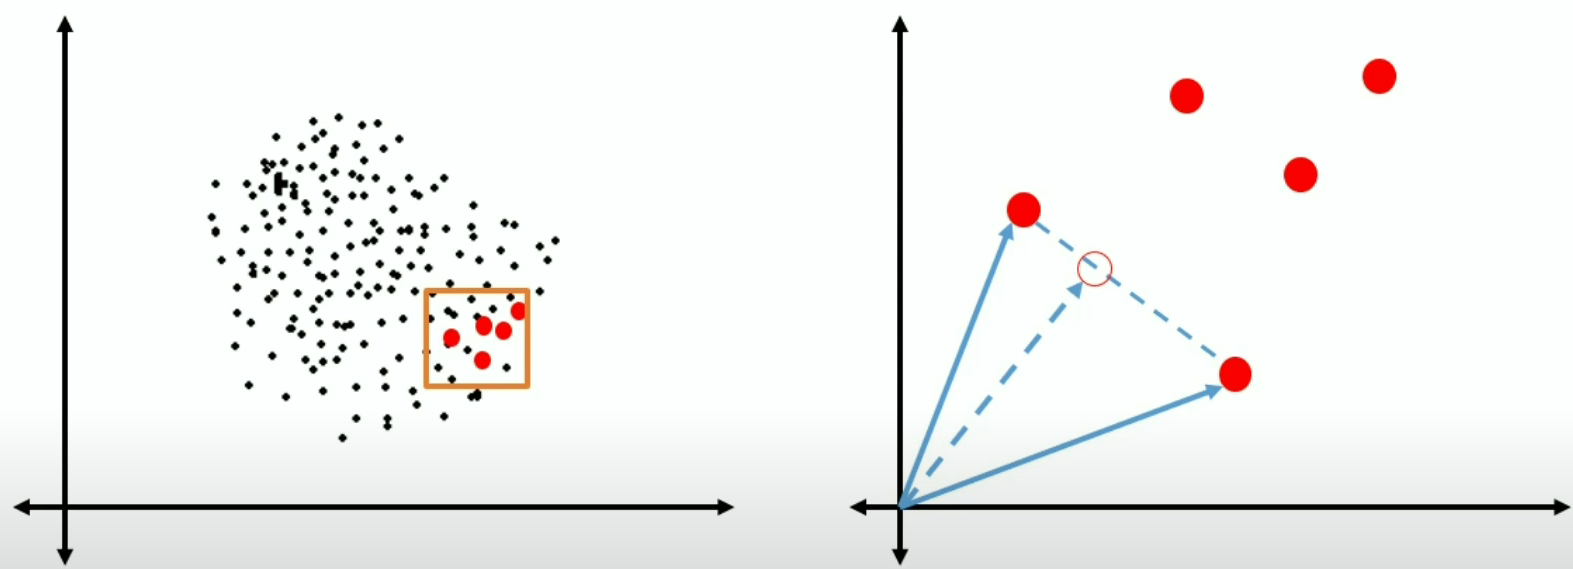

Let's now use **SHAP** and **permutation importance** to determine the **importance of each feature**.

In [23]:
y = df['y'] ## response 
X = df.drop('y',axis=1) ## design matrix

X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.2, ## we will leave 20% to test our models on later. 
                                                    random_state=42, ## make our work reproducible
                                                    stratify = y)  ## same amount of ppl who are/are not happy in the training and test set


sm = SMOTE(random_state=42)
rf = DecisionTreeClassifier(random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)
rf.fit(X_train,y_train)
explainer = shap.TreeExplainer(rf)

## Shap values are arrays of a length corresponding to the number of classes in target.
## Here, we have 2 classes.
shap_values = explainer.shap_values(X_test)

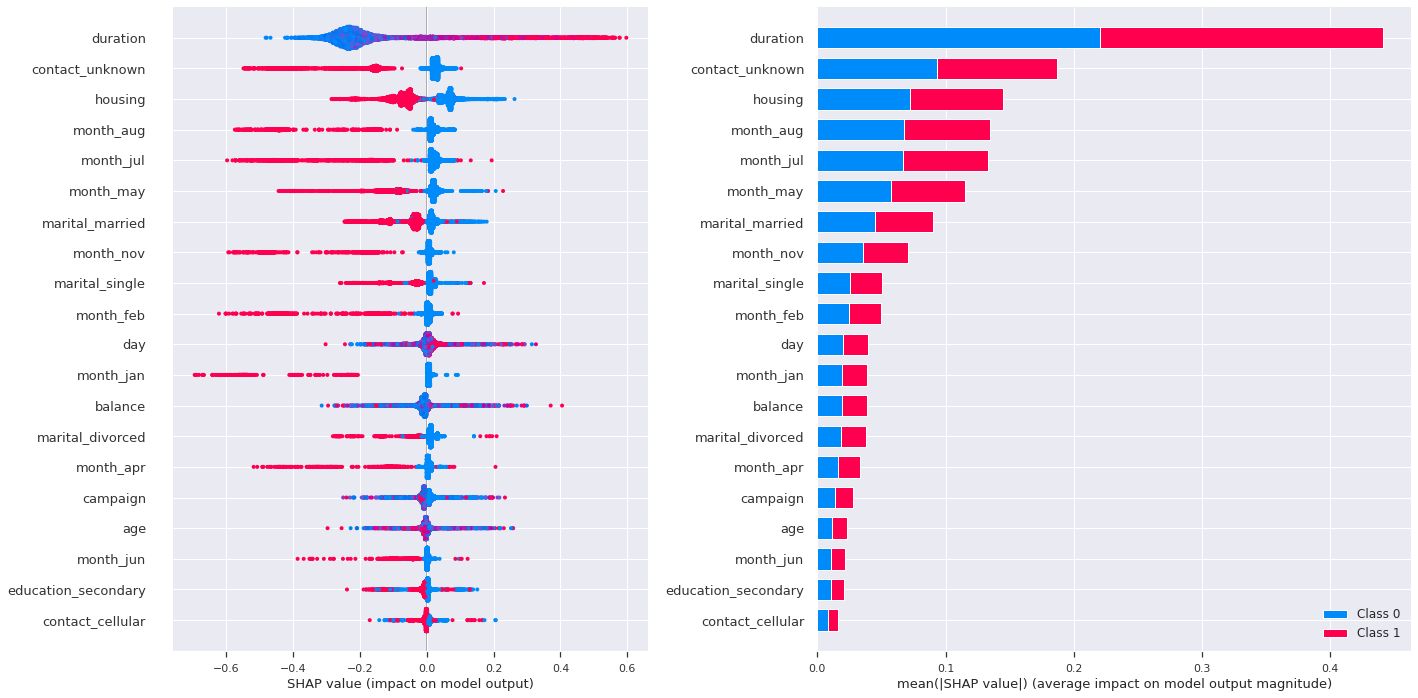

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values[1], X_test, plot_size=None,show=False)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=None,show=False)
plt.tight_layout()
plt.show()

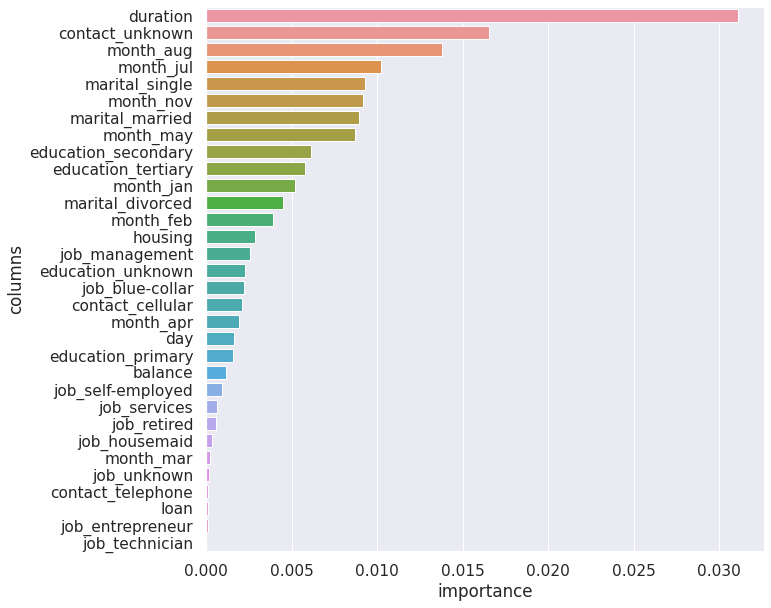

In [25]:
## We call permuation_importance and input the fitted model as model parameter
## We call it on test set, since it calculates the feature importance via its performance on our test set

result = permutation_importance(RandomForestClassifier(random_state=42).fit(X_train, y_train), X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

## plot the features against importance  
df_ = pd.DataFrame({'columns': X_test.columns, 'importance':result.importances_mean})
df_ = df_.loc[df_['importance']>0].sort_values(['importance'],ascending=False).reset_index()
plt.subplots(1,figsize=(10,10))
sns.barplot(x="importance",y="columns",data=df_)
plt.show()

**"duration"** is by far the most important feature for both classes of the target variable.

In [26]:
df_final = df[['duration','y']].copy()
df_final.head()

,duration,y
0,261,0
1,151,0
2,76,0
3,92,0
4,198,0


In [27]:
y = df_final['y'] ## response 
X = df_final.drop('y',axis=1) ## design matrix


## split the data into training and test data sets

X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.2, ## we will leave 20% to test our models on later. 
                                                    random_state=42, ## make our work reproducible
                                                    stratify=y) 

In [28]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ["rf", RandomForestClassifier(random_state=42)]])
                                             

In [29]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                  shuffle=True,
                                  random_state=42)

In [30]:
param_grid = {"rf__n_estimators": [500], ## number of trees used in random forest
                 "rf__max_depth": [10], ## max depth 
                 "rf__criterion": ["gini"], ## to check whether impurity or information gain is the best way to split
                 "rf__min_samples_leaf": [20], ## minimum samples beyond which a node cannot be split
                 "rf__max_features": ["sqrt"], ## to check what is the best way to limit the number of features to each tree
                 "rf__bootstrap": [True] ## to check whether bagging and aggregating results in a better model 
                 } 

In [31]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='average_precision',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [32]:
model_rf = grid_search.fit(X_train, y_train)
print(model_rf.best_params_)

{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 20, 'rf__n_estimators': 500}


Balanced accuracy score:  0.7204
Precision score: 0.9241
Recall score: 0.9230
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7421
           1       0.47      0.48      0.48       579

    accuracy                           0.92      8000
   macro avg       0.71      0.72      0.72      8000
weighted avg       0.92      0.92      0.92      8000



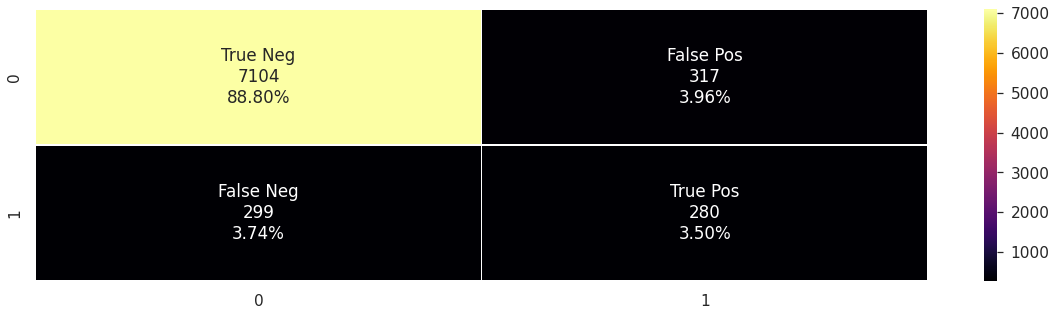

In [33]:
## train the model using the best estimator
pipe = model_rf.best_estimator_
model = pipe.fit(X_train, y_train)

threshold = 0.85
predicted = model.predict_proba(X_test)
predicted = (predicted[:,1] >= threshold).astype('int')

# ## predictions
# #y_pred_rf = model.predict(X_test)
y_pred_rf = predicted

## HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix = confusion_matrix(y_test, y_pred_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='inferno',linewidths=0.3)

## metric scores on test set
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")

## classification report
clf_report = classification_report(y_test, y_pred_rf)

print(f"Classification Report : \n{clf_report}")

**Observations:**
- RandomForests can deal with outliers and not scaled data, thus we did not do anything about those things.
- A threshold was introduced when the model predicts on the test data in order to reduce the False Positives.
- The model has an accuracy of 92%, but we should focus on the precision, recall and F1-scores of each class.
- Both precision and recall of the major class (Not Subscribed) are extremly high, 96%. This means that our model can detect 96% of those who will not subscribe with 96% precision. 
- On the other hand, both recall and precision of the minor class (Subscribed) are close to 50%. This means that only about 50% of those who will subscribe will be detected by our model. Also, around 50% of our model's predictions will be wrong (53% of False positives).

**Overall:**
- Our model is very good at predicting those who will Not Subscribe, so the company can save time and not bother calling them, but it is not so good at predicting if someone will Subscribe.

**We can examine each prediction individually using SHAP.**

In [34]:
rf = DecisionTreeClassifier(random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)
rf.fit(X_train,y_train)
explainer = shap.TreeExplainer(rf)

## Shap values are arrays of a length corresponding to the number of classes in target.
## Here, we have 2 classes.
shap_values = explainer.shap_values(X_test)

In [35]:
# # Initialize JavaScript visualizations in notebook environment
shap.initjs()
k = 110 ## controls which row to examine
print(f'The label for row {k} in the test set is: {y_test.iloc[k]}')
shap.force_plot(explainer.expected_value[1], shap_values[1][k], X_test.iloc[k])

The label for row 110 in the test set is: 0


**Let's cluster the customers.**

In [36]:
X_ = df_final.copy()
X_['duration'] = X_['duration']/60

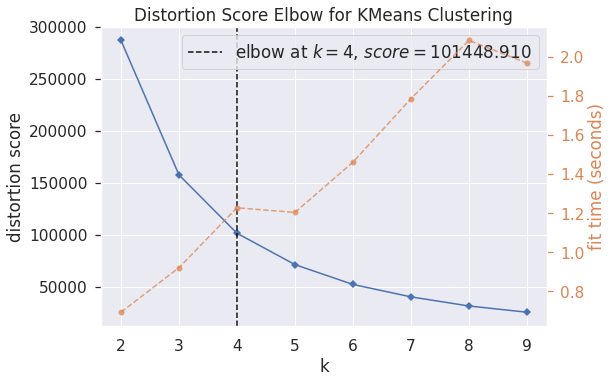

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd900887c10>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [37]:
kelbow_visualizer(KMeans(random_state=42), X_, k=(2,10))

NOTE: 
 - **Distortion** is the sum of the squared distances between each observation vector and its dominating centroid.
 - Using the **elbow method**, we find that k=4 is the optimal number of clusters.

In [38]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_)

In [39]:
y_kmeans= kmeans.predict(X_)

In [40]:
df_cluster = df_final.copy()
df_cluster['cluster'] = y_kmeans
#df_cluster['duration'] = np.log(df_cluster['duration']+1)
df_cluster['duration'] = df_cluster['duration']/60

In [41]:
df_cluster.head()

,duration,y,cluster
0,4.350000,0,3
1,2.516667,0,0
2,1.266667,0,0
3,1.533333,0,0
4,3.300000,0,0


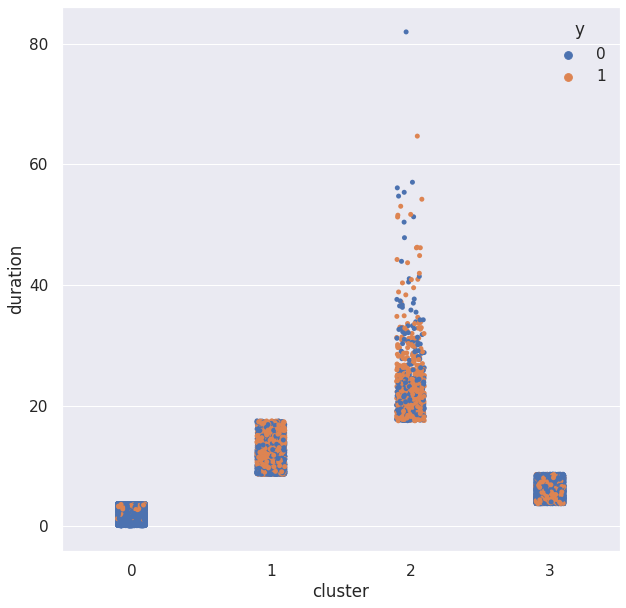

In [42]:
plt.figure(figsize=(10,10))
sns.stripplot(data=df_cluster,x='cluster',y='duration', hue='y')

In [43]:
per_cluster0 = df_cluster[(df_cluster['cluster']==0) & (df_cluster['y']==1)].shape[0] / df_cluster[df_cluster['cluster']==0].shape[0]
per_cluster1 = df_cluster[(df_cluster['cluster']==1) & (df_cluster['y']==1)].shape[0] / df_cluster[df_cluster['cluster']==1].shape[0]
per_cluster2 = df_cluster[(df_cluster['cluster']==2) & (df_cluster['y']==1)].shape[0] / df_cluster[df_cluster['cluster']==2].shape[0]
per_cluster3 = df_cluster[(df_cluster['cluster']==3) & (df_cluster['y']==1)].shape[0] / df_cluster[df_cluster['cluster']==3].shape[0]

per_clusters = [per_cluster0, per_cluster1, per_cluster2, per_cluster3]

for i in range(4):
  print(f'{round(per_clusters[i],4)*100}% in cluster {i} have subscribed to a term-deposit.')
  print('---------------------------------------------------------------------')

1.5599999999999998% in cluster 0 have subscribed to a term-deposit.
---------------------------------------------------------------------
35.6% in cluster 1 have subscribed to a term-deposit.
---------------------------------------------------------------------
59.830000000000005% in cluster 2 have subscribed to a term-deposit.
---------------------------------------------------------------------
6.54% in cluster 3 have subscribed to a term-deposit.
---------------------------------------------------------------------


In [44]:
median_duration0 = df_cluster[(df_cluster['cluster']==0) & (df_cluster['y']==1)]['duration'].median()
median_duration1 = df_cluster[(df_cluster['cluster']==1) & (df_cluster['y']==1)]['duration'].median()
median_duration2 = df_cluster[(df_cluster['cluster']==2) & (df_cluster['y']==1)]['duration'].median()
median_duration3 = df_cluster[(df_cluster['cluster']==3) & (df_cluster['y']==1)]['duration'].median()

median_clusters = [median_duration0, median_duration1, median_duration2, median_duration3]

for i in range(4):
  print(f'The median duration of those who have subscribed to a term deposit in cluster {i} was {round(median_clusters[i],2)} minutes.')
  print('---------------------------------------------------------------------')

The median duration of those who have subscribed to a term deposit in cluster 0 was 2.56 minutes.
---------------------------------------------------------------------
The median duration of those who have subscribed to a term deposit in cluster 1 was 12.07 minutes.
---------------------------------------------------------------------
The median duration of those who have subscribed to a term deposit in cluster 2 was 21.28 minutes.
---------------------------------------------------------------------
The median duration of those who have subscribed to a term deposit in cluster 3 was 6.15 minutes.
---------------------------------------------------------------------


In [45]:
print('Cluster 1:')
print(round(df_cluster[(df_cluster['cluster']==1) & (df_cluster['y']==1)]['duration'].min(),0))
print(round(df_cluster[(df_cluster['cluster']==1) & (df_cluster['y']==1)]['duration'].max(),0))

print('------------')
print('Cluster 2:')
print(round(df_cluster[(df_cluster['cluster']==2) & (df_cluster['y']==1)]['duration'].min(),0))
print(round(df_cluster[(df_cluster['cluster']==2) & (df_cluster['y']==1)]['duration'].max(),0))

Cluster 1:
9.0
17.0
------------
Cluster 2:
17.0
65.0


**Conclusion.**

A client who is interested in bying the investement product will likely want to know more about it. Hence, the company should focus on the last contact duration. Specifically, the company should prioritize clients with last contact duration around $17-65$ minutes and then $9-17$ minutes. Also, using our model above the company will be able to save a huge amount of time by not contacting the clients that are more likely to not subscribe.